In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

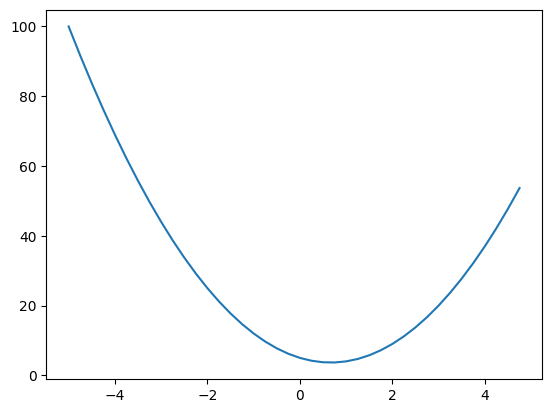

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
h = 0.0000001
x = 2/3
(f(x+h) - f(x))/h

2.9753977059954195e-07

In [7]:
a = 2.0
b = -3.0
c = 10.0
c
print(c)

10.0


In [8]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [78]:
class Value:
    def __init__(self, data, _children=(), _op = '', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda : None
    
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        # gradient on addition is just 1
        # the += mark for multivariable case, we accumulate the gradient for each node
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        # derivative total is just local derivative * global derivative
        # the += mark for multivariable case, we accumulate the gradient for each node
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x) +1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()

        # topological sorting : kindda like DFS sorting -> go to the bottom of the leaf, then change brance
        # its used so we can automaticly search for the backward propagation
        def build_topo(v):
            if v not in visited: 
                visited.add(v)
                for child in v._prev: 
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')


In [11]:
from graphviz import Digraph

# tracing all the nodes and edges from the calculation
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"}) # Lr = left to right
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # creating the rectangular node
        dot.node(name=uid, label= "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            # creating the circle operation node
            dot.node(name=uid + n._op, label= n._op)
            dot.edge(uid+n._op, uid)
    # creatiing edges
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


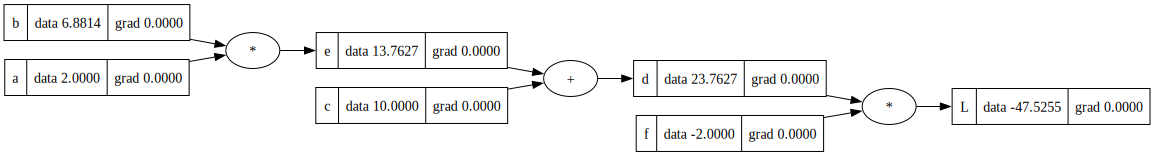

In [22]:
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
draw_dot(L)

In [14]:
def derivative_example():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

derivative_example()

6.000000000000227


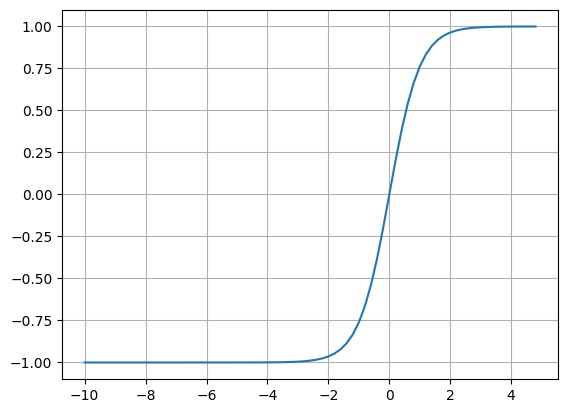

In [18]:
plt.plot(np.arange(-10,5,0.2), np.tanh(np.arange(-10,5,0.2))); plt.grid();

In [74]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

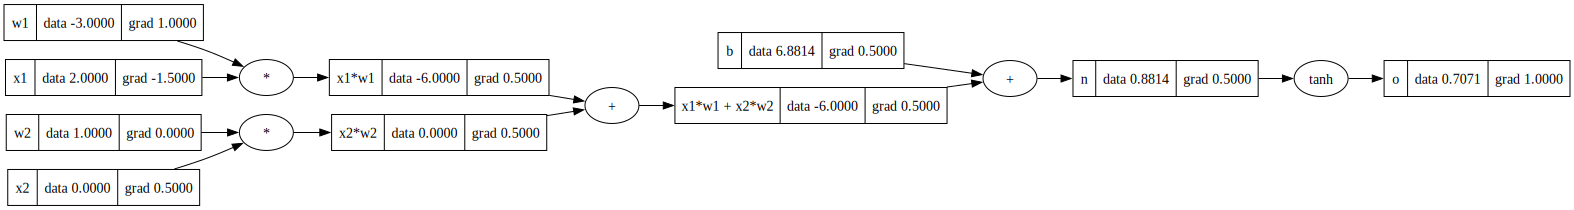

In [77]:
draw_dot(o)

In [76]:
o.backward()

In [71]:
o.grad = 1.0

topo = []
visited = set()

# topological sorting : kindda like DFS sorting -> go to the bottom of the leaf, then change brance
# its used so we can automaticly search for the backward propagation
def build_topo(v):
    if v not in visited: 
        visited.add(v)
        for child in v._prev: 
            build_topo(child)
        topo.append(v)

build_topo(o)

for node in reversed(topo):
    node._backward()

topo

[Value(data = 6.881373587019543),
 Value(data = 1.0),
 Value(data = 0.0),
 Value(data = 0.0),
 Value(data = 2.0),
 Value(data = -3.0),
 Value(data = -6.0),
 Value(data = -6.0),
 Value(data = 0.8813735870195432),
 Value(data = 0.7071067811865476)]

In [56]:
o.grad = 1.0

In [57]:
o._backward()

In [59]:
n._backward()

In [61]:
b._backward()

In [63]:
x1w1x2w2._backward()

In [65]:
x2w2._backward()

In [66]:
x1w1._backward()

In [45]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [43]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [41]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [39]:
# grad on x1w1x2w2 + b
b.grad = 0.5
x1w1x2w2.grad = 0.5

In [ ]:
o.grad = 1.0

In [37]:
n.grad = 0.5

In [36]:
1-o.data**2

0.4999999999999999

In [ ]:
# o = tanh(n)
# do/dn = 1-tanh(n)**2


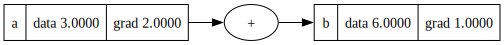

In [79]:
a = Value(3.0, label="a")
b = a + a; b.label="b"
b.backward()
draw_dot(b)

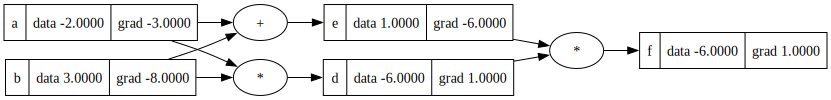

In [80]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)